In [9]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import math

import optuna#载入optuna优化包

device = torch.device('cpu')

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

xtrain = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1).to(device)
ytrain = (torch.sin(math.pi*xtrain) + 0.2*torch.randn(xtrain.size())).to(device)  

#测试数据
SEED = 666
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

ytest = (torch.sin(math.pi*xtrain) + 0.2*torch.randn(xtrain.size())).to(device)  

In [10]:
class SigmoidP(nn.Module):  # Sigmoid激活函数含噪声参数
    def __init__(self, trial):
        super().__init__()
        self.sigma = trial.suggest_float("sigma", 0.1, 10.0)  # 设置 sigma 为可学习参数
        
    def forward(self, input):
        temp = 1/(1+torch.exp(-input/self.sigma))  # SigmoidP 的前向传播
        return temp
#这里还是呼应我们的广义激活函数模型y=1-F(-x)，因为有什么样子的噪声PDF概率密度函数f，那么就能找到对应的
#CDF累计分布函数F(x)，那么不同的噪声就能得到不同的激活函数形式，选择高斯分布得到GEU，选择logistic noise 
# PDF f_\eta(x)=e^{-x/\sigma}/[\sigma(1+e^{-x/\sigma})^2] with variance $\sigma^2\pi^2/3$,
#这种噪声的CDF是 F_\eta(x)= 1/(1+e^{-x/\sigma}), 则
# y=1-F(-x) = 1- 1/(1+e^{x/\sigma}) = 1/(1+e^{-x/\sigma})
#那么就是简单把GEU换成SigmoidP，即带参数的Sigmoid激活函数，超参数sigma一样起到相同的效果，能够防止过拟合

class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output, trial):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.custom1 = SigmoidP(trial)  # 自定义激活函数层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = self.custom1(x)
        x = self.predict(x)  # 前向传播过程
        return x

def objective(trial):
    # 在 objective 函数中创建网络实例并将 trial 对象传递给构造函数
    net = Net(n_feature=1, n_hidden1=10, n_output=1, trial=trial).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.96, 0.96))
    loss_func = torch.nn.MSELoss().to(device)  # MSE损失函数
    epoch = 20000
    
    # 定义变量来存储最小损失和对应的最优参数
    min_loss = float('inf')
    best_params = None
    best_weights = None
    
    for t in range(epoch):
        prediction = net(xtrain)  # 前向过程
        loss = loss_func(prediction, ytrain) # 计算mse
 
        ##后向传播更新
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward(retain_graph=True)    # 反向传播
        optimizer.step()        # 更新参数
        
        # 检查当前损失是否是最小损失，并更新最优参数
        if loss < min_loss:
            min_loss = loss
            best_params = trial.params.copy()
            best_weights = net.state_dict()
    ## 根据intermediate value进行剪枝，加快贝叶斯寻优过程        
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    # 保存最优权重到文件中
    torch.save(best_weights, 'D:/贝叶斯优化与噪声注入/best_weights.pth')
    
    # 将最优参数和损失存储到合适的位置
    study.set_user_attr('best_params', best_params)  # 存储最优参数到Study对象中
    study.set_user_attr('best_loss', min_loss.item())  # 存储最小损失到Study对象中
    
    output = net(xtrain)  
    # test误差
    losstest = loss_func(ytest, output)
    return losstest.item()


In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# 输出结果
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-16 22:20:15,306] A new study created in memory with name: no-name-4517c625-251f-45a8-9948-e5231e17af18
[I 2024-03-16 22:20:27,531] Trial 0 finished with value: 0.04320267215371132 and parameters: {'sigma': 3.0571148996614372}. Best is trial 0 with value: 0.04320267215371132.
[I 2024-03-16 22:20:39,606] Trial 1 finished with value: 0.03474115952849388 and parameters: {'sigma': 9.900869318231287}. Best is trial 1 with value: 0.03474115952849388.
[I 2024-03-16 22:20:51,494] Trial 2 finished with value: 0.04371177405118942 and parameters: {'sigma': 1.924250880112283}. Best is trial 1 with value: 0.03474115952849388.
[I 2024-03-16 22:21:03,545] Trial 3 finished with value: 0.03519655019044876 and parameters: {'sigma': 6.60916999407237}. Best is trial 1 with value: 0.03474115952849388.
[I 2024-03-16 22:21:15,977] Trial 4 finished with value: 0.04550690948963165 and parameters: {'sigma': 2.8705331596681742}. Best is trial 1 with value: 0.03474115952849388.
[I 2024-03-16 22:21:28,45

Best trial:
  Value:  0.034475166350603104
  Params: 
    sigma: 8.583957425144762


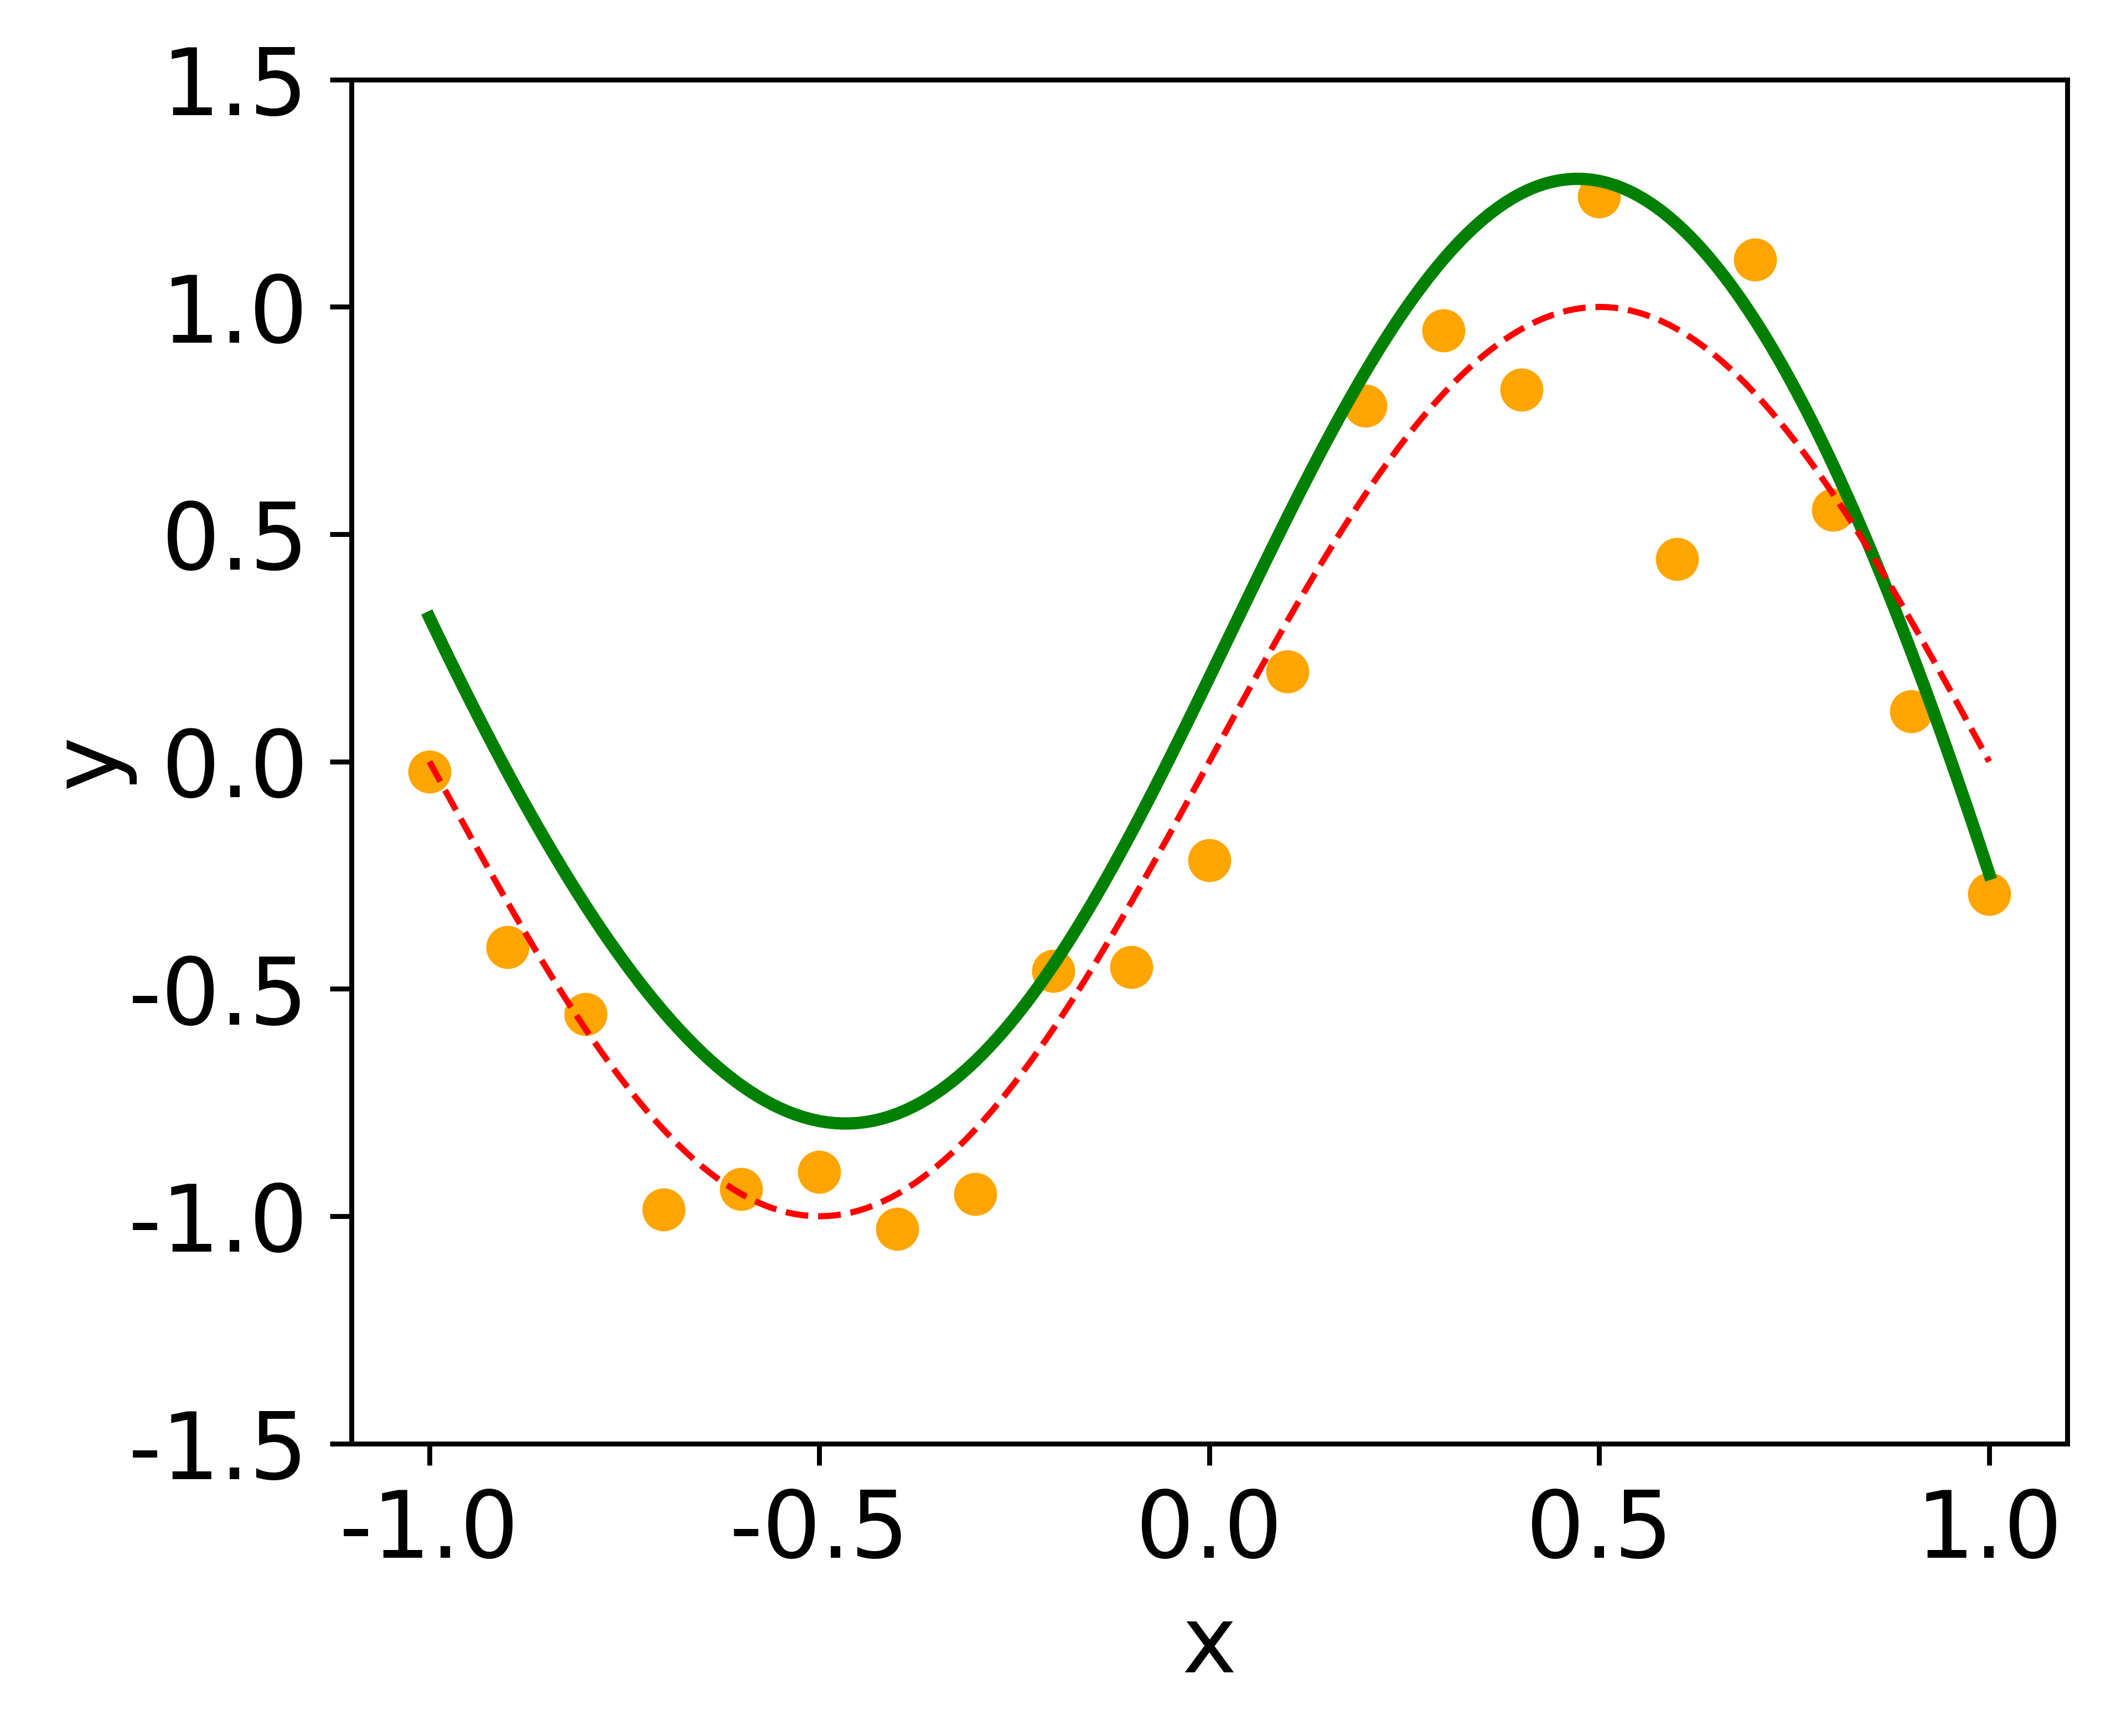

In [12]:
#在求出最优sigma的基础上运行网络
class SigmoidP(nn.Module):  # 激活函数含噪声参数
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma  # 直接接收 sigma 参数
        
    def forward(self, input):
        temp = 1/(1+torch.exp(-input/self.sigma))   #  前向传播
        return temp

class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output, sigma):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.custom1 = SigmoidP(sigma)  # 自定义激活函数层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = self.custom1(x)
        x = self.predict(x)  # 前向传播过程
        return x

# 获取最佳试验参数
best_trial = study.best_trial

best_weights = torch.load('D:/贝叶斯优化与噪声注入/best_weights.pth')

# 使用最优试验参数和加载的权重参数重新初始化网络
best_sigma = best_trial.params['sigma']
best_net = Net(n_feature=1, n_hidden1=10, n_output=1, sigma=best_sigma)
best_net.load_state_dict(best_weights)

# 获取网络的输出
inputx= torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1).to(device)
output = best_net(inputx).to(device)

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(xtrain.data.numpy(), ytrain.data.numpy(), color="orange")
 # 非常密的输入和网络输出
ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')